FileName = ImgSegmentation_CallBack.ipynb

The code in this notebook demonstrates TF/Keras callback feature for using a pre-compiled model for prediction in production.

These are the steps to create/train/test the model and store its parameters:

1. The model was defined and compiled in the notebook ImgSegmentation.ipynb.
2. The model was trained, tested, validated in ImgSegmentation.ipynb. 
3. While training, ImgSegmentation.ipynb stored the model parameters using the TF/Keras callback feature.
4. Once the model was trained and its parameters saved, the model's accuracy and loss were evaluated
   by ImgSegmentation.ipynb using training, testing and validation data. Evaluation charts were plotted   

These are the steps to upload the model and use it for prediction during production

1. Get the data to be used. In this case we will use data from the same source 
2. Uploads the data from files and do pre-processing to get the data into memory, in the same format that was used during training.
3. The model is uploaded using the TF/Keras call feature
4. Data is selected for prediction.
5. The uploaded model returns a prediction, which needs to be compared versus the target.
6. The prediction and the targer are displayed
7. The (cosine) similarity between prediction and target is calculated.
8. Repeat steps 4..7



In [1]:
# get the APIs

import os, shutil

import numpy as np
import matplotlib.pyplot as plt 
import random 

import tensorflow as tf
import keras 
from keras import layers, models, optimizers
from keras.layers import Dropout
from keras.datasets import mnist
from keras.utils import load_img, img_to_array
from keras.utils import array_to_img

print ("TF Version   ", tf.__version__)
print ("TF Path      ", tf.__path__[0])
print("Keras version ", keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-22 02:03:21.278627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740189801.292497       9 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740189801.296377       9 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 02:03:21.311339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF Version    2.18.0
TF Path       /usr/local/lib/python3.11/site-packages/keras/api/_v2
Keras version  3.8.0
Num GPUs Available:  1


In [2]:

dataDir = "./imgSegExcercise/Oxford_iiit_pets/"
codeDir = "./imgSegExcercise/Playground/"

# prepare data
# dataDir = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/"
# codeDir = "/drv3/hm3/code/python/tf2.18/tf2.18/local/ImgSegmentation/Playground/"
input_dir  = dataDir + "images/"   # contains the 7,394 images
target_dir = dataDir +  "annotations/trimaps/"


# there are 7390 files in input_img_paths is discussed.
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])

# there are 7390 files in target_img_paths
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])



In [3]:
# The code in this cell takes time to run because all the 7K
# images are loaded into memory in a shape of (200, 200, RGB)

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000

# train_input_imgs and train_targets contain 6390 files 
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

# val_input_imgs and val_targets contain 1000 files
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]


In [4]:
# Below is the model that was defined in ImgSegmentation.ipynb  

""" 
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model
    
model = get_model(img_size=img_size, num_classes=3)
model.summary()
keras.utils.plot_model( model, to_file= codeDir + "ImgSegmentation.png" )
"""

' \ndef get_model(img_size, num_classes):\n    inputs = keras.Input(shape=img_size + (3,))\n    x = layers.Rescaling(1./255)(inputs)\n\n    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)\n    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)\n    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)\n    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)\n    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)\n    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)\n\n    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)\n    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)\n    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)\n    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)\n    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)\n    x 

In [4]:
# Below is the code used in ImgSegmentation to compile and  train (fit) the model
# The only action in this cell is to define the callback_dir

callback_dir = codeDir + "oxford_pets_segmentation_01.keras"

"""
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [ keras.callbacks.ModelCheckpoint(callback_dir, save_best_only=True) ]

history = model.fit(train_input_imgs, train_targets, verbose=0,
                    # epochs=50,
                    epochs=20,
                    callbacks=callbacks,
                    # batch_size=64,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))
"""                    


'\nmodel.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")\ncallbacks = [ keras.callbacks.ModelCheckpoint(callback_dir, save_best_only=True) ]\n\nhistory = model.fit(train_input_imgs, train_targets, verbose=0,\n                    # epochs=50,\n                    epochs=20,\n                    callbacks=callbacks,\n                    # batch_size=64,\n                    batch_size=32,\n                    validation_data=(val_input_imgs, val_targets))\n'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


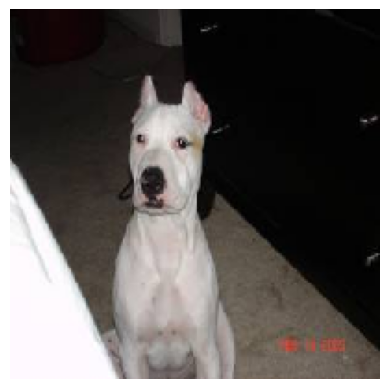

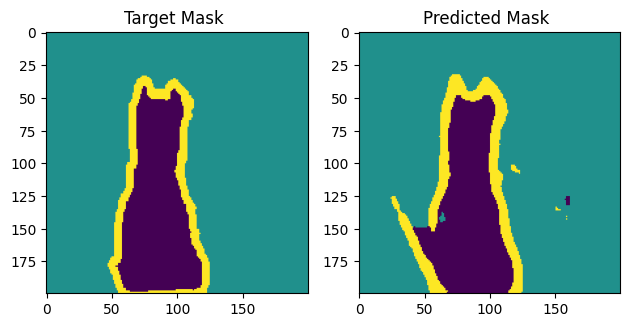

In [8]:

callback_dir = codeDir + "oxford_pets_segmentation_01.keras"

# get the model that was learned in ImgSegmentation.ipynb
model = keras.models.load_model(callback_dir)

# use the 4th image to evaluate predictions in production
i = 4
input_image = val_input_imgs[i]
target_mask = val_targets[i]

plt.axis("off")
plt.imshow(array_to_img(input_image))

# get the predicted mask for the input image from the model
pred_mask = model.predict(np.expand_dims(input_image, 0))[0]

def process_mask( m ):
    mask = np.argmax(m, axis=-1)
    mask *= 127
    return mask

# process the predicted mask to get the same colors as the original
pred_mask_1 = process_mask (pred_mask)

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2)
  
# Plot input Img 
axis[0].imshow(target_mask)
axis[0].set_title("Target Mask ")
  
# For target Img 
axis[1].imshow(pred_mask_1)
axis[1].set_title("Predicted Mask ")

# Combine imgs in a tight layout  
plt.tight_layout() 
plt.show()


In [9]:
# plot training and vaidation loss 

""" 
Unfortunately we can't load the history (of the training) directly from a loaded model. If we really need to
get that history, we have to set it up in advance using CSVLogger, which is a convenient way of storing the 
entire training history in a separate file. In this way we can come back later and plot the history of the training
instead of being dependent on a variable we can easily lose stored in the RAM).

More info at

https://keras.io/api/callbacks/

from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training.log', separator=',', append=False)
model.fit(X_train, Y_train, callbacks=[csv_logger])

import pandas as pd
log_data = pd.read_csv('training.log', sep=',', engine='python')
"""

""" 
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
""" 

""" 
Instead of plotting training/validation loss/accuracy that would be given by the
history obj, we can instead evaluate the accuracy of the model by measuring
the similarity between a mask from the training set versus a mask from the validation set,
because the latter has not been seen by the model.  

Cosine similarity is a simnple meathod we can use to mesure similarity between arrays using 
code like below

""" 
# import required libraries
import numpy as np
from numpy.linalg import norm
 
# define two lists or array to test the code for cosine similarity
A = np.array([2,1,2,3,2,9])
B = np.array([3,4,2,4,5,5])
C = np.array([2,1,2,3,2,9])
D = np.array([3,4,2,4,5,5])
print("A:", A)
print("B:", B)
 
# This is the formula to compute cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity:", cosine)

# compute cosine similarity
cosine = np.dot(A,C)/(norm(A)*norm(C))
print("Cosine Similarity should be = 1.0 : ", cosine)






m1 = target_mask.reshape(-1)
m2 = pred_mask_1.reshape(-1)
op1 = np.dot(m1,m2)
op2 = (norm(m1)*norm(m2))
cos = op1 / op2
print("Cosine Similarity (target mask vs predicted mask) = ", cos)
#op1 = np.dot(test_image, mask.T)
#op2 = (norm(test_image)*norm(mask))
# imgCosine = np.dot(test_image,mask)/(norm(test_image)*norm(mask))



A: [2 1 2 3 2 9]
B: [3 4 2 4 5 5]
Cosine Similarity: 0.8188504723485274
Cosine Similarity should be = 1.0 :  1.0
Cosine Similarity (target mask vs predicted mask) =  0.9572303655266052


## Modelo 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


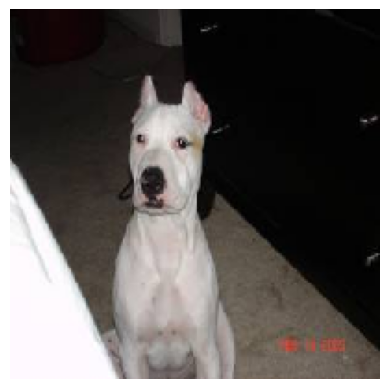

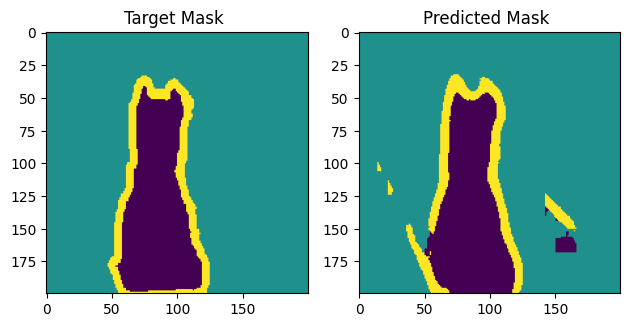

In [6]:

callback_dir = codeDir + "EncoderDecoder.keras"

# get the model that was learned in ImgSegmentation.ipynb
model = keras.models.load_model(callback_dir)

# use the 4th image to evaluate predictions in production
i = 4
input_image = val_input_imgs[i]
target_mask = val_targets[i]

plt.axis("off")
plt.imshow(array_to_img(input_image))

# get the predicted mask for the input image from the model
pred_mask = model.predict(np.expand_dims(input_image, 0))[0]

def process_mask( m ):
    mask = np.argmax(m, axis=-1)
    mask *= 127
    return mask

# process the predicted mask to get the same colors as the original
pred_mask_1 = process_mask (pred_mask)

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2)
  
# Plot input Img 
axis[0].imshow(target_mask)
axis[0].set_title("Target Mask ")
  
# For target Img 
axis[1].imshow(pred_mask_1)
axis[1].set_title("Predicted Mask ")

# Combine imgs in a tight layout  
plt.tight_layout() 
plt.show()


In [7]:
# # import required libraries
# import numpy as np
# from numpy.linalg import norm
 
# define two lists or array to test the code for cosine similarity
A = np.array([2,1,2,3,2,9])
B = np.array([3,4,2,4,5,5])
C = np.array([2,1,2,3,2,9])
D = np.array([3,4,2,4,5,5])
print("A:", A)
print("B:", B)
 
# This is the formula to compute cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity:", cosine)

# compute cosine similarity
cosine = np.dot(A,C)/(norm(A)*norm(C))
print("Cosine Similarity should be = 1.0 : ", cosine)

m1 = target_mask.reshape(-1)
m2 = pred_mask_1.reshape(-1)
op1 = np.dot(m1,m2)
op2 = (norm(m1)*norm(m2))
cos = op1 / op2
print("Cosine Similarity (target mask vs predicted mask) = ", cos)
#op1 = np.dot(test_image, mask.T)
#op2 = (norm(test_image)*norm(mask))
# imgCosine = np.dot(test_image,mask)/(norm(test_image)*norm(mask))

A: [2 1 2 3 2 9]
B: [3 4 2 4 5 5]
Cosine Similarity: 0.8188504723485274
Cosine Similarity should be = 1.0 :  1.0
Cosine Similarity (target mask vs predicted mask) =  0.9633215317634276
